yt : [INFO     ] 2024-03-28 16:18:26,739 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-28 16:18:26,739 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-03-28 16:18:26,740 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-03-28 16:18:26,740 Parameters: domain_right_edge         = [1.         3.14159265 6.28318531]
yt : [INFO     ] 2024-03-28 16:18:26,741 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-03-28 16:18:26,744 Making a fixed resolution buffer of (('index', 'ones')) 10 by 10
yt : [INFO     ] 2024-03-28 16:18:27,531 Making a fixed resolution buffer of (('index', 'ones')) 453 by 453
yt : [INFO     ] 2024-03-28 16:18:27,565 Making a fixed resolution buffer of (('index', 'ones')) 896 by 896
yt : [INFO     ] 2024-03-28 16:18:27,671 Making a fixed resolution buffer of (('index', 'ones')) 1340 by 1340
yt : [INFO     ] 2024-03-28 16:18:27,884 Making a fixed resolution buffer of (('index', 'ones')) 

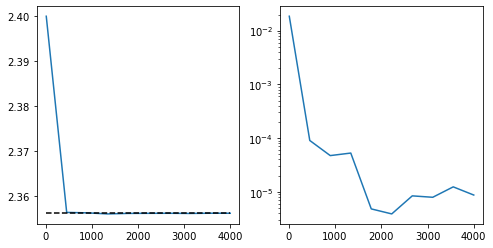

In [1]:
import numpy as np
import yt
from yt.testing import fake_amr_ds
import matplotlib.pyplot as plt

shp = (128, 128, 128)
data = {"density": np.random.random(shp)}

bbox = np.array([[0.0, 1.0], [0, np.pi], [0, 2 * np.pi]])


ds = yt.load_uniform_grid(
    data,
    shp,
    bbox=bbox,
    geometry="spherical",
    axis_order=("r", "theta", "phi"),
    length_unit="m",
)

normal = np.array([0.0, 0.0, 1.0])
center = np.array([0.0, 0., 0.5])

slc = ds.cartesian_cutting(normal, center)
approx_areas = []
res_vals = np.linspace(10, 4000, 10).astype(int)
for res in res_vals:
    frb = slc.to_frb(2.0, res)
    vals = frb["index", "ones"]
    msk = frb.get_mask(("index", "ones"))
    vals[~msk] = 0.0
    
    # get the approximate area 
    dx = (frb.bounds[1] - frb.bounds[0]) / frb.buff_size[0]
    dy = (frb.bounds[3] - frb.bounds[2]) / frb.buff_size[1]
    area_approx = vals.sum() * dx * dy 
    area_approx = area_approx.d
    approx_areas.append(area_approx)
    
ro = np.sqrt(1.0**2 - center[2]**2)
area = np.pi * ro * ro

approx_areas = np.array(approx_areas)
error = np.abs(approx_areas - area) / area 

f, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
axs[0].plot(res_vals, approx_areas)
axs[0].plot([0, res_vals[-1]], [area, area], '--k')

axs[1].semilogy(res_vals, error)
plt.show()